# Benchmark


In [ ]:
import numpy as np

from pepme.core import (
    FeatureCache,
    barplot,
    compute_metrics,
    random_subset,
    show_table,
)
from pepme.embeddings.property_embedding import PropertyEmbedding
from pepme.metrics.fid import FID
from pepme.metrics.id import ID
from pepme.metrics.novelty import Novelty
from pepme.properties.normalizers import MinMaxNorm
from pepme.properties.physico_chemical import Gravy, MolecularWeight
from pepme.utils import read_fasta_file


Let's load the datasets.


In [21]:
DATASET_PATHS = {
    "AMP-Diffusion": "../data/amp-diffusion.fasta",
    "AMP-GAN": "../data/amp-gan.fasta",
    "CPL-Diff": "../data/cpl-diff.fasta",
    "HydrAMP": "../data/hydramp.fasta",
    "OmegAMP": "../data/omegamp.fasta",
    "DBAASP": "../data/dbaasp.fasta",
    "UniProt": "../data/uniprot/uniprot_8_50_100.fasta",
}

In [22]:
datasets = {name: read_fasta_file(path) for name, path in DATASET_PATHS.items()}

In [23]:
for model_name, sequences in datasets.items():
    print(f"{model_name}: {len(sequences)} sequences")

AMP-Diffusion: 47671 sequences
AMP-GAN: 150000 sequences
CPL-Diff: 49985 sequences
HydrAMP: 50000 sequences
OmegAMP: 149504 sequences
DBAASP: 8967 sequences
UniProt: 2933310 sequences


Let's define the metrics.


In [25]:
n_samples = 50_000
seed = 42

benchmark_datasets = {
    name: random_subset(sequences, n_samples=n_samples, seed=seed)
    if len(sequences) > n_samples
    else sequences
    for name, sequences in datasets.items()
}


# @TODO: replace with ESM2 when implemented
def my_embedder(sequences: list[str]) -> np.ndarray:
    lengths = [len(sequence) for sequence in sequences]
    counts = [sequence.count("K") for sequence in sequences]
    return np.array([lengths, counts]).T


physico_chemical_embedder = PropertyEmbedding(
    predictors=[
        MinMaxNorm(Gravy()),
        MinMaxNorm(MolecularWeight()),
    ]
)

cache = FeatureCache(
    models={"embedder": my_embedder, "physico-chemical": physico_chemical_embedder}
)


metrics = [
    Novelty(reference=benchmark_datasets["DBAASP"], reference_name="DBAASP"),
    FID(
        reference=benchmark_datasets["DBAASP"],
        embedder=cache.model("physico-chemical"),
        reference_name="DBAASP",
    ),
    ID(Gravy(), name="Gravy", objective="minimize"),
]

In [26]:
df = compute_metrics(benchmark_datasets, metrics)

100%|██████████| 21/21 [00:01<00:00, 16.30it/s, data=UniProt, metric=Gravy]             


Let's look at the results.


In [28]:
show_table(df, decimals=[4, 2, 2])

,Novelty (DBAASP)↑,FID (DBAASP)↓,Gravy↓
AMP-Diffusion,0.9993,0.12,-0.16±0.80
AMP-GAN,0.9986,0.22,0.02±0.81
CPL-Diff,0.9970,0.04,-0.15±1.20
HydrAMP,1.0000,0.13,-0.41±0.99
OmegAMP,0.9803,0.00,-0.33±1.03
DBAASP,0.0000,0.00,-0.33±1.00
UniProt,0.9999,0.24,-0.18±0.73


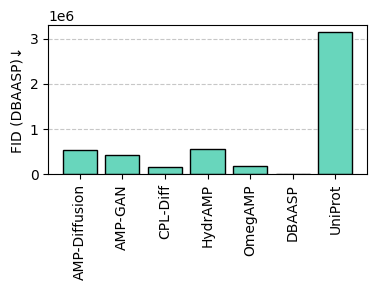

In [8]:
barplot(df, "FID (DBAASP)", x_ticks_label_rotation=90)